In [1]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

device='cuda'

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# define resnet model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)  # update final layer

    def forward(self, x):
        return self.mobilenet(x)
    
def train_model(model, dataloader, epochs=5, downsample_factor=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy()  # to numpy
            if downsample_factor > 1:
                inputs = downsample_resolution(inputs, downsample_factor)  # downsample
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)  # back to tensor

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

def downsample_resolution(images, factor):
    h, w = images.shape[2:]  # height and width of images
    new_h, new_w = h // factor, w // factor
    downsampled = np.zeros((images.shape[0], images.shape[1], new_h, new_w))  # output shape

    for i in range(new_h):
        for j in range(new_w):
            patch = images[:, :, i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
            avg_patch = np.mean(patch, axis=(2, 3))  # mean across height and width
            downsampled[:, :, i, j] = avg_patch

    return downsampled

# pca wrapper (top 16 pcs!)
def compute_pca(images, n_components=16):
    flat_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flat_images)  # normalize!
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled_images)
    return pcs


def estimate_mi(model, dataloader, downsample_factor=1):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()  # to numpy
            if downsample_factor > 1:
                inputs = downsample_resolution(inputs, downsample_factor)  # downsample
            inputs = torch.tensor(inputs).to(device).float()  # back to tensor
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            predicted_labels.append(preds)

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)

    mi = lmi.ksg.midd(true_labels, predicted_labels)
    mean_mi = np.nanmean(mi)
    print(f"Estimated Mutual Information: {mean_mi:.4f}")
    return mean_mi


In [3]:
MIs = []

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((224, 224)),  # resize to a manageable resolution
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform,)


N = len(Caltech101)

train_set, val_set = torch.utils.data.random_split(Caltech101, [1280, N-1280])
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
# # extract images and labels
# images, labels = [], []
# for batch in data_loader:
#     images.append(batch[0].numpy())
#     labels.append(batch[1].numpy())
# images = np.concatenate(images, axis=0)
# labels = np.concatenate(labels, axis=0)

# print(labels)
# downsample resolution :)


Files already downloaded and verified


In [4]:

# different downsampling factors
factors = [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100]
print("factors to process:", factors)

# process each factor
for factor in factors:
    print(f"downsampling by factor {factor}...")

    model = ResNetClassifier(num_classes=101)
    model.to('cuda')
    train_model(model, data_loader, epochs=5, downsample_factor=factor)

    # estimate mutual info
    mi = estimate_mi(model, val_loader, downsample_factor=factor)
    print(f"factor {factor} -> MI: {mi:.4f}")

print("mutual information results:", MIs)

/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


factors to process: [1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100]
downsampling by factor 1...
Epoch 1/5, Loss: 4.1800
Epoch 2/5, Loss: 2.9985
Epoch 3/5, Loss: 2.4545
Epoch 4/5, Loss: 2.0214
Epoch 5/5, Loss: 1.6477
Estimated Mutual Information: 3.8304
factor 1 -> MI: 3.8304
downsampling by factor 2...
Epoch 1/5, Loss: 4.2983
Epoch 2/5, Loss: 2.9437
Epoch 3/5, Loss: 2.3240
Epoch 4/5, Loss: 1.8632
Epoch 5/5, Loss: 1.4813
Estimated Mutual Information: 3.4828
factor 2 -> MI: 3.4828
downsampling by factor 4...
Epoch 1/5, Loss: 4.4741
Epoch 2/5, Loss: 3.1842
Epoch 3/5, Loss: 2.5343
Epoch 4/5, Loss: 2.0842
Epoch 5/5, Loss: 1.6966
Estimated Mutual Information: 2.1662
factor 4 -> MI: 2.1662
downsampling by factor 5...
Epoch 1/5, Loss: 4.5195
Epoch 2/5, Loss: 3.2667
Epoch 3/5, Loss: 2.6098
Epoch 4/5, Loss: 2.1365
Epoch 5/5, Loss: 1.7804
Estimated Mutual Information: 1.8608
factor 5 -> MI: 1.8608
downsampling by factor 8...
Epoch 1/5, Loss: 4.5127
Epoch 2/5, Loss: 3.5189
Epoch 3/5, Loss: 2.9298
Epoch 4

In [5]:
import pandas as pd
import seaborn as sns

In [6]:
d = {"MIs" : MIs, 
     "Downsampling Factors" : factors
     }

df = pd.DataFrame(data=d)
df

,MIs,Downsampling Factors
0,3.830411,1
1,3.482793,2
2,2.166170,4
3,1.860758,5
4,1.364601,8
5,1.084615,10
6,0.870864,20
7,0.641417,25
8,0.633630,40
9,0.593453,50


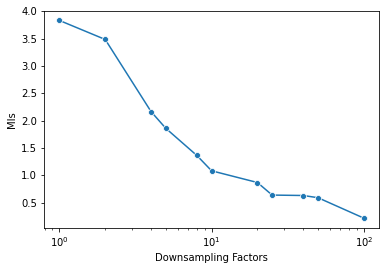

In [7]:
sns.lineplot(x="Downsampling Factors", y="MIs", data=df, marker='o')
plt.xscale('log')

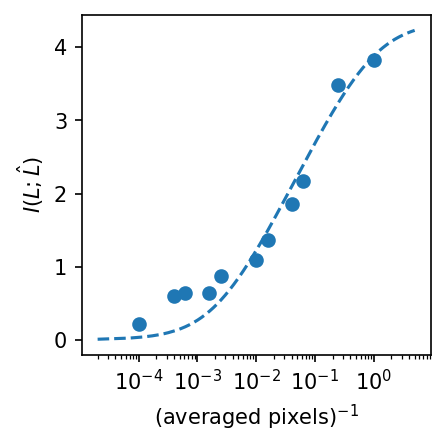

In [23]:
from scipy.optimize import curve_fit
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

x_data = 1/(df['Downsampling Factors']**2)
y_data = df['MIs']
popt, pcov = curve_fit(info_scaling, x_data, y_data, 
                        p0 = [10**-2, 10**-2], bounds=[(0, 0), (np.inf, np.inf)])

x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)

fig = plt.figure(figsize=(3,3), dpi=150)
plt.xlabel(r'$\text{(averaged pixels)}^{-1}$')
plt.ylabel(r'$I(L; \hat{L})$')
plt.scatter(x_data, y_data)
plt.plot(x_fit, info_scaling(x_fit, *popt), linestyle='--')
plt.xscale('log')

In [15]:
images, labels = [], []
for batch in data_loader:
    images.append(batch[0].numpy())
    labels.append(batch[1].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


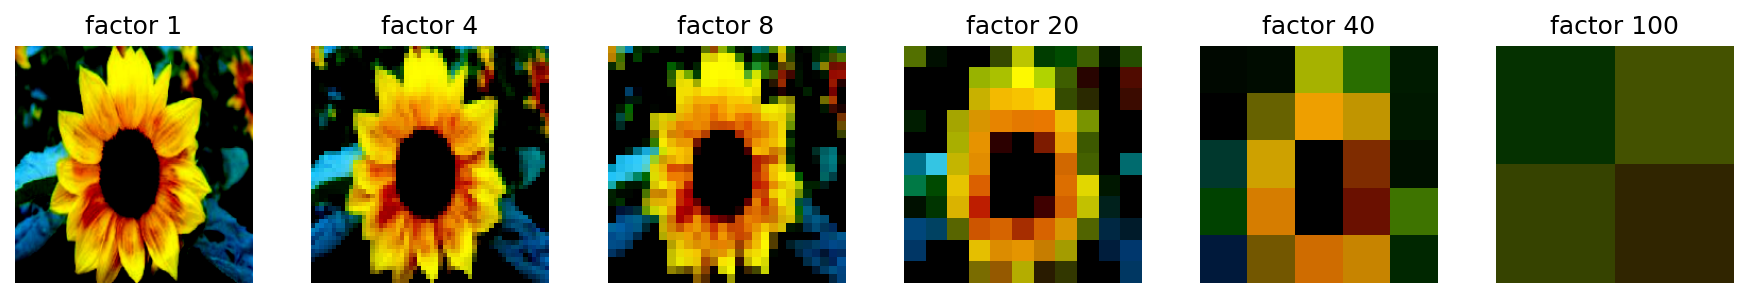

In [25]:
# label 90 is the good label


fig, axes = plt.subplots(1, len(factors[::2]), figsize=(12, 2), dpi=150)  # adjust figsize as needed
for idx, f in enumerate(factors[::2]):
    downsampled = downsample_resolution(images[1], f)
    for i in range(len(images[0])):
        if labels[1][i] == 90:
            axes[idx].axis('off')
            axes[idx].imshow(downsampled.transpose(0, 2, 3, 1)[i])
            axes[idx].set_title(f"factor {f}")
            break

plt.tight_layout()
plt.show()